In [1]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parents[1]))
from runs import find_runs  # noqa: E402

In [2]:
location_error = pd.DataFrame()
velocity_error = pd.DataFrame()
velocity_error_relative = pd.DataFrame()

# Iterate over all runs
for run_path in find_runs(working_dir.parent):
    # Read parameters.json
    with open(run_path / "parameters.json") as file:
        parameters = json.load(file)

    # Calculate mean L2 error norm for each timestep
    location_error_data = []
    velocity_error_data = []
    velocity_error_relative_data = []
    indices = []
    for timestep_path in (run_path / "solution").glob("*_particles_*.pvtu"):
        mesh = pv.read(timestep_path)

        # Calculate error norm for each particle
        mesh["location_error"] = np.linalg.norm(
            mesh.points - mesh["analytical_location"], axis=1
        )

        # For the velocity, we calculate the relative error
        mesh["velocity_error"] = np.linalg.norm(
            mesh["velocity"] - mesh["analytical_velocity"], axis=1
        )
        mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
            mesh["analytical_velocity"], axis=1
        )

        # Calculate median error norm over all particles
        location_error_data.append(mesh["location_error"].mean())
        velocity_error_data.append(mesh["velocity_error"].mean())
        velocity_error_relative_data.append(np.median(mesh["velocity_error_relative"]))

        # Use the timestep number from the filename as index
        indices.append(int(timestep_path.stem.split("_")[-1]))

    # Generate descriptive column name
    column_name = {
        "nearest-neighbor": "NN",
        "rbf-pum-direct": "RBF",
    }[parameters["mapping"]]

    if parameters["mapping"] == "rbf-pum-direct":
        column_name += (
            "_"
            + {
                "compact-polynomial-c0": "CP0",
                "compact-polynomial-c2": "CP2",
                "compact-polynomial-c4": "CP4",
                "compact-polynomial-c6": "CP6",
                "compact-polynomial-c8": "CP8",
            }[parameters["basis_function"]]
        )

        column_name += f"_{parameters['support_radius']}"

    column_name += f"_{parameters['refinement']}"

    # Insert into DataFrame
    location_error[column_name] = pd.Series(data=location_error_data, index=indices)
    velocity_error[column_name] = pd.Series(data=velocity_error_data, index=indices)
    velocity_error_relative[column_name] = pd.Series(
        data=velocity_error_relative_data, index=indices
    )

In [3]:
# Sort columns by name
location_error.sort_index(inplace=True, axis=1)
velocity_error.sort_index(inplace=True, axis=1)
velocity_error_relative.sort_index(inplace=True, axis=1)

# Sort rows by timestep number
location_error.sort_index(inplace=True, axis=0)
velocity_error.sort_index(inplace=True, axis=0)
velocity_error_relative.sort_index(inplace=True, axis=0)

In [4]:
velocity_error.filter(like="NN", axis=1).describe()

,NN_0,NN_1,NN_10,NN_11,NN_2,NN_3,NN_4,NN_5,NN_6,NN_7,NN_8,NN_9
count,201.000000,201.000000,113.000000,7.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.561234,0.561234,0.011393,0.135391,0.221679,0.116575,0.053118,0.027829,0.016330,0.010899,0.008812,0.008243
std,0.271512,0.271512,0.085355,0.341778,0.096105,0.071401,0.064445,0.063496,0.063630,0.063838,0.063949,0.063984
min,0.001381,0.001381,0.001375,0.006011,0.001381,0.001381,0.001381,0.001381,0.001381,0.001381,0.001381,0.001378
25%,0.337570,0.337570,0.001423,0.006124,0.173903,0.086121,0.032578,0.014332,0.007048,0.003730,0.002353,0.001785
50%,0.625144,0.625144,0.002883,0.006229,0.259275,0.132133,0.055847,0.025948,0.012917,0.006771,0.004378,0.003543
75%,0.814994,0.814994,0.005251,0.006391,0.278614,0.143491,0.066876,0.032791,0.016504,0.009074,0.006264,0.005511
max,0.911145,0.911145,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470


In [5]:
velocity_error.filter(like="RBF_CP4", axis=1).describe()

,RBF_CP4_0.5_0,RBF_CP4_0.5_1,RBF_CP4_0.5_2,RBF_CP4_0.5_3,RBF_CP4_0.5_4,RBF_CP4_0.5_5,RBF_CP4_0.5_6,RBF_CP4_0.5_7,RBF_CP4_0.5_8,RBF_CP4_0.5_9
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.561234,0.561234,0.180933,0.016286,0.008136,0.008094,0.008093,0.008093,0.008093,0.008093
std,0.271512,0.271512,0.085781,0.063528,0.063991,0.063994,0.063995,0.063995,0.063995,0.063995
min,0.001381,0.001381,0.001381,0.001381,0.001381,0.001373,0.001373,0.001373,0.001373,0.001373
25%,0.337570,0.337570,0.136789,0.010428,0.001672,0.001596,0.001592,0.001592,0.001592,0.001592
50%,0.625144,0.625144,0.188472,0.012976,0.003432,0.003347,0.003346,0.003345,0.003345,0.003345
75%,0.814994,0.814994,0.241969,0.014860,0.005458,0.005415,0.005419,0.005419,0.005420,0.005420
max,0.911145,0.911145,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470


In [6]:
velocity_error.filter(like="RBF_CP8", axis=1).describe()

,RBF_CP8_0.5_0,RBF_CP8_0.5_1,RBF_CP8_0.5_2,RBF_CP8_0.5_3,RBF_CP8_0.5_4,RBF_CP8_0.5_5,RBF_CP8_0.5_6,RBF_CP8_0.5_7,RBF_CP8_0.5_8
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.561234,0.561234,0.331560,0.018883,0.008131,0.008093,0.008093,0.008093,0.008093
std,0.271512,0.271512,0.133711,0.063415,0.063992,0.063995,0.063995,0.063995,0.063995
min,0.001381,0.001381,0.001381,0.001381,0.001380,0.001373,0.001373,0.001373,0.001373
25%,0.337570,0.337570,0.247229,0.012903,0.001657,0.001593,0.001592,0.001592,0.001592
50%,0.625144,0.625144,0.350575,0.016036,0.003400,0.003345,0.003345,0.003345,0.003345
75%,0.814994,0.814994,0.444563,0.017900,0.005452,0.005418,0.005420,0.005420,0.005420
max,0.911145,0.911145,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470,0.910470


array([<Axes: xlabel='timestep'>, <Axes: xlabel='timestep'>,
       <Axes: xlabel='timestep'>], dtype=object)

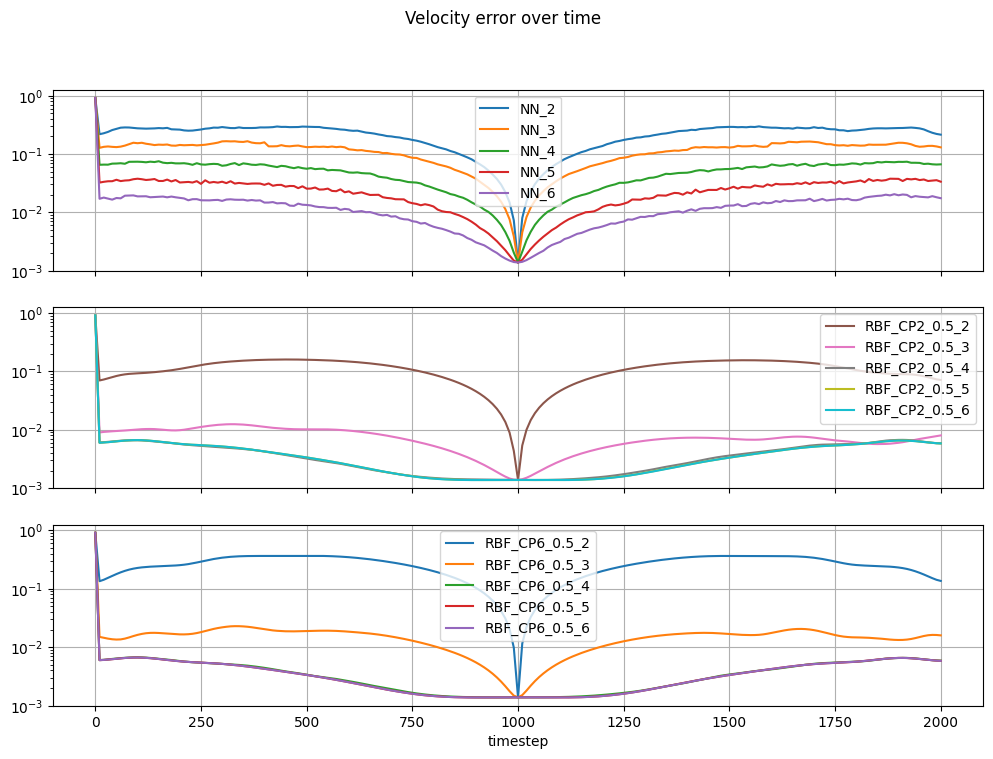

In [7]:
velocity_error.filter(
    axis=1,
    items=[
        "NN_2",
        "NN_3",
        "NN_4",
        "NN_5",
        "NN_6",
        "RBF_CP2_0.5_2",
        "RBF_CP2_0.5_3",
        "RBF_CP2_0.5_4",
        "RBF_CP2_0.5_5",
        "RBF_CP2_0.5_6",
        "RBF_CP6_0.5_2",
        "RBF_CP6_0.5_3",
        "RBF_CP6_0.5_4",
        "RBF_CP6_0.5_5",
        "RBF_CP6_0.5_6",
    ],
).plot(
    title="Velocity error over time",
    figsize=(12, 8),
    grid=True,
    xlabel="timestep",
    logy=True,
    sharey=True,
    subplots=[
        (
            "NN_2",
            "NN_3",
            "NN_4",
            "NN_5",
            "NN_6",
        ),
        (
            "RBF_CP2_0.5_2",
            "RBF_CP2_0.5_3",
            "RBF_CP2_0.5_4",
            "RBF_CP2_0.5_5",
            "RBF_CP2_0.5_6",
        ),
        (
            "RBF_CP6_0.5_2",
            "RBF_CP6_0.5_3",
            "RBF_CP6_0.5_4",
            "RBF_CP6_0.5_5",
            "RBF_CP6_0.5_6",
        ),
    ],
)